In [2]:
%load_ext autoreload
%autoreload 2
from typing import List

from copy import copy
from itertools import combinations, permutations
import pickle
from random import choice, random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

In [125]:
from cube import Cube3D

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

We try to address the 3rd question from the previous notebook.

## Define the target for the greedy algorithm
What 'sort loss' function we use for a rubik's cube?

$$
\text{SL} = \sum_{i=1}^{n-1} \sum_{j=i+1}^{n} [x_i > x_j]
$$

Maybe stick to this one? With only difference in excluding zeroes (for the rubik's cube case)

In [4]:
def sort_loss(input: List[int]) -> float:
    loss = 0
    for i in range(len(input)):
        for j in range(i, len(input)):
            if input[i] > input[j] and all([input[i] > 0, input[j] > 0]):
                loss += 1
    return loss


In [5]:
sort_loss([0, 2,1,3, 0, 4])

1

How we define this group's actions?

Each side has a pattern of [1 2 3 4 5 6 7 8] -> [7 8 1 2 3 4 5 6]

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|


4 possible action types:

I.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|<span style="color:blue">c</span>|<span style="color:blue">d</span>|<span style="color:blue">e</span>|<span style="color:blue">f</span>|<span style="color:blue">g</span>|<span style="color:blue">h</span>|<span style="color:blue">a</span>|<span style="color:blue">b</span>|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|

II.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c|d|e|f|g|h|<span style="color:blue">k</span>|<span style="color:blue">l</span>|<span style="color:blue">m</span>|<span style="color:blue">n</span>|<span style="color:blue">o</span>|<span style="color:blue">p</span>|<span style="color:blue">i</span>|<span style="color:blue">j</span>|q|r|s|t|u|v|w|x|

III.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b||d|e|f|g||i|j||l|m|n|o||||||u|v|w|x|

IV.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c||e|f||h|i|j|k||m|n||p|q|r|s|t|||||

The train data can be easily generated for the greedy algorithm and fixed sequence length as the most optimal action in terms of previously defined 'sort loss':

In [7]:
cube = np.array([x for x in range(1, 28)])
cube

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [8]:
cube.reshape(3,3,3)

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[10, 11, 12],
        [13, 14, 15],
        [16, 17, 18]],

       [[19, 20, 21],
        [22, 23, 24],
        [25, 26, 27]]])

In [21]:
def generate_cube(n):
    return np.array([x for x in range(1, n**3+1)]).reshape(n, n, n)

In [22]:
cube = generate_cube(3)
cube

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[10, 11, 12],
        [13, 14, 15],
        [16, 17, 18]],

       [[19, 20, 21],
        [22, 23, 24],
        [25, 26, 27]]])

In [23]:
def plot_cube(cube):
    N = cube.shape[0]
    axes = [N, N, N] # change to 64
    alpha = 0.5
    colors = np.empty(axes + [4], dtype=np.float32)
    colors[cube < 10] = [1, 1, 0, alpha]
    colors[(cube > 9) & (cube < 19)] = [1, 0, 0, alpha]
    colors[cube > 18] = [0, 0, 1, alpha]
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.voxels(
        cube,
        facecolors=colors,
        edgecolors='black'
    )
    plt.show()

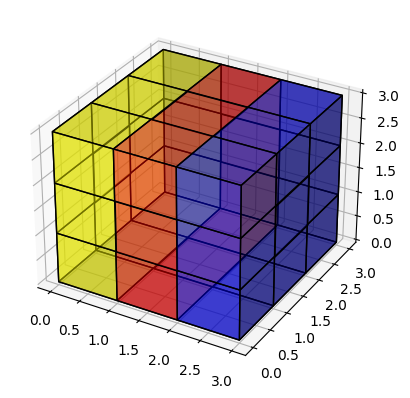

In [24]:
plot_cube(cube)

In [36]:
def rotate_cube(cube, axi, level, clockwise=True):
    _r = 1 if clockwise is True else -1
    if axi not in (0, 1, 2):
        raise ValueError('`axi` must be one of {0, 1, 2}')
    if level > cube.shape[0] - 1:
        raise ValueError('`level` must be less then maximal index of a cube\'s side')
    if axi == 0:
        cube = np.rot90(cube, k=1, axes=(0,1))
        cube[level] = np.rot90(cube[level], k=_r, axes=(0, 1))
        cube = np.rot90(cube, k=-1, axes=(0,1))
    elif axi == 1:
        cube = np.rot90(cube, k=1, axes=(0,2))
        cube[level] = np.rot90(cube[level], k=_r, axes=(0, 1))
        cube = np.rot90(cube, k=-1, axes=(0,2))
    else:
        cube = np.rot90(cube, k=1, axes=(1,2))
        cube[level] = np.rot90(cube[level], k=_r, axes=(0, 1))
        cube = np.rot90(cube, k=-1, axes=(1,2))
    return cube

In [91]:
for _ in range(500):
    rotate_cube(cube, choice([0, 1, 2]), choice([0, 1, 2]), clockwise=choice([True, False]))

In [92]:
sort_loss(cube.reshape(27))

156

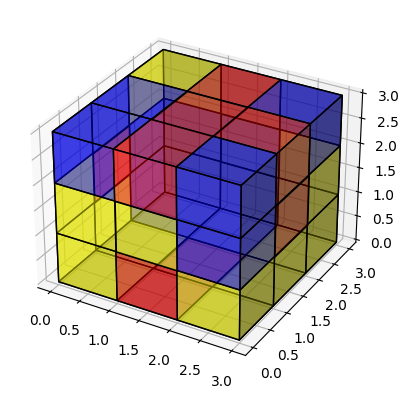

In [93]:
plot_cube(cube)

In [86]:
cube

array([[[21, 18, 27],
        [20, 13, 12],
        [ 9, 16,  7]],

       [[ 4, 11, 22],
        [23, 14,  5],
        [ 6, 17, 24]],

       [[19, 26,  3],
        [10, 15,  2],
        [ 1,  8, 25]]])

## Prepare train data

Input - reshaped to 1-D array cube. <br>
Output - best next action in terms of sort loss optimization (including "ideal"). <br><br>

Output can be assessed as the best next step, best next step leading to better second next step and so on. <br>
So we will try:
- 1 step
- 2 step
- 3 step
optimizations.

In [182]:
cube = Cube3D(3)

In [255]:
cube.mix_cube()
cube.sort_loss()

128

In [250]:
cube.apply_action(1)

array([[[21, 12, 19],
        [ 2, 15, 10],
        [25, 24,  1]],

       [[26,  5, 18],
        [17, 14, 11],
        [ 4, 23, 20]],

       [[27, 16,  9],
        [ 6, 13,  8],
        [ 7, 22,  3]]])

In [254]:
cube.sort_loss()

146

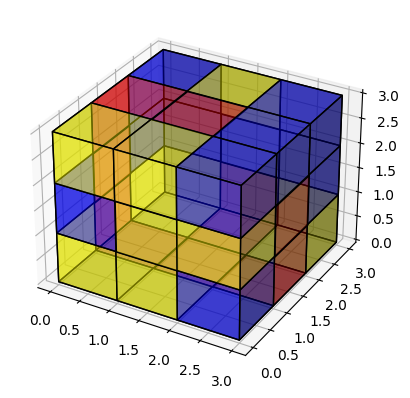

In [256]:
cube.plot_cube()

In [110]:
# generate simple data
N = 2  # size of the cube's side
SEQ_LEN = N*N*6
SOURCE = [x for x in range(SEQ_LEN)]
DATASET_SIZE = 500

DATA = []

SAMPLES = list(permutations(SOURCE, SEQ_LEN))
_picked = set()
for _ in range(DATASET_SIZE):
    v = choice(SAMPLES)
    if v not in _picked:
        _picked.add(v)

    swap_chosen = None
    for swap in get_actions_possible(list(v)):
        if swap_chosen is None:
            swap_chosen = swap
        if sort_loss(swap) < sort_loss(swap_chosen):
            swap_chosen = swap
    
    DATA.append((list(v), swap_chosen))

Simple sanity check

In [112]:
for i, row in enumerate(DATA):
    if i > 9:
        break
    print('------------------\n')
    print(row)
    print('------------------\n')
    for v in get_actions_possible(row[0]):
        print(v, sort_loss(v))
    print('-------------------\n')

------------------

([5, 6, 2, 4], [5, 2, 6, 4])
------------------

[6, 5, 2, 4] 5
[5, 2, 6, 4] 3
[5, 6, 4, 2] 5
-------------------

------------------

([0, 3, 5, 6], [3, 0, 5, 6])
------------------

[3, 0, 5, 6] 1
[0, 5, 3, 6] 1
[0, 3, 6, 5] 1
-------------------

------------------

([3, 0, 2, 6], [0, 3, 2, 6])
------------------

[0, 3, 2, 6] 1
[3, 2, 0, 6] 3
[3, 0, 6, 2] 3
-------------------

------------------

([3, 4, 6, 0], [3, 4, 0, 6])
------------------

[4, 3, 6, 0] 4
[3, 6, 4, 0] 4
[3, 4, 0, 6] 2
-------------------

------------------

([6, 3, 4, 5], [3, 6, 4, 5])
------------------

[3, 6, 4, 5] 2
[6, 4, 3, 5] 4
[6, 3, 5, 4] 4
-------------------

------------------

([5, 3, 1, 4], [3, 5, 1, 4])
------------------

[3, 5, 1, 4] 3
[5, 1, 3, 4] 3
[5, 3, 4, 1] 5
-------------------

------------------

([2, 3, 5, 4], [2, 3, 4, 5])
------------------

[3, 2, 5, 4] 2
[2, 5, 3, 4] 2
[2, 3, 4, 5] 0
-------------------

------------------

([2, 1, 6, 3], [1, 2, 6, 3])
------

### Split data

In [113]:
SPLIT_RATE = 0.9
train_data = []
test_data = []
for row in DATA:
    if random() < SPLIT_RATE:
        train_data.append(row)
    else:
        test_data.append(row)

In [114]:
len(train_data)

454

### Dump data

In [115]:
with open('../data/train.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('../data/test.pkl', 'wb') as f:
    pickle.dump(test_data, f)

### Load data

In [116]:
with open('../data/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('../data/test.pkl', 'rb') as f:
    test_data = pickle.load(f)

### Define a simple sorter neural network

In [127]:
class SorterNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(SorterNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [141]:
input_train_data = torch.tensor([x[0] for x in train_data], dtype=torch.float32)
output_train_data = torch.tensor([x[1] for x in train_data], dtype=torch.float32)

input_test_data = torch.tensor([x[0] for x in test_data], dtype=torch.float32)
output_test_data = torch.tensor([x[1] for x in test_data], dtype=torch.float32)    

In [142]:
input_size = input_train_data.shape[1]
output_size = output_train_data.shape[1]
hidden_size = 64
model = SorterNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [143]:
num_epochs = 5000
for epoch in range(num_epochs):
    outputs = model(input_train_data)
    loss = criterion(outputs, output_train_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1000/5000], Loss: 0.1867
Epoch [2000/5000], Loss: 0.0803
Epoch [3000/5000], Loss: 0.0554
Epoch [4000/5000], Loss: 0.0430
Epoch [5000/5000], Loss: 0.0331


In [144]:
test_data[0]

([5, 3, 1, 4], [3, 5, 1, 4])

In [156]:
test_input = torch.tensor([[5, 3, 1, 4]], dtype=torch.float32)
predicted_output = model(test_input).round()
print("Predicted Output:", predicted_output.detach().numpy())

Predicted Output: [[3. 5. 1. 4.]]


In [150]:
for v in get_actions_possible([3, 5, 1, 4]):
    print(v, sort_loss(v))

[5, 3, 1, 4] 4
[3, 1, 5, 4] 2
[3, 5, 4, 1] 4


In [157]:
test_input = torch.tensor([[3, 5, 1, 4]], dtype=torch.float32)
predicted_output = model(test_input).round()
print("Predicted Output:", np.round(predicted_output.detach().numpy()))

Predicted Output: [[3. 1. 5. 4.]]


Let's test the sorting

In [178]:
sample = test_data[0][0]
v = sort_loss(sample)

print(f'Input:\t {sample}')
i = 1
while v > 0:
    test_input = torch.tensor([sample], dtype=torch.float32)
    predicted_output = model(test_input).round()
    sample = predicted_output.detach().numpy().astype(int).tolist()[0]
    v = sort_loss(sample)
    print(f'Step {i}:\t', sample, f'\tSort loss: {v}')
    i += 1

Input:	 [5, 3, 1, 4]
Step 1:	 [3, 5, 1, 4] 	Sort loss: 3
Step 2:	 [3, 1, 5, 4] 	Sort loss: 2
Step 3:	 [1, 3, 5, 4] 	Sort loss: 1
Step 4:	 [1, 3, 4, 5] 	Sort loss: 0


So it looks like now we have a model that has trained the best movements for given permutations. 

Things to consider:
1. **what if the input consists of random unexpected values?**
   <br>_If the elements live in a metric space we assume them as sortable and thus, they can be indexed with known/expected intervals and sorted after that._ 
2. **what if the input is very large?**
   <br>_This can be handled by eating the elephant one bite at a time. We can break the input into acceptable parts and sort them independently. Once all parts are sorted we apply the merge-sort strategy. If the chunks are stil very big we can apply the same algorithm recursively. Yet the solution is designed for the fixed input only which is already a limitation._
3. **how to define sort loss and possible actions for a more sophisticated group?**